In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

2023-06-22 16:19:17.980238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 16:19:21.451420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/lotus_DB_as_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features_dummy.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/mol_dummy_rdkit.csv", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_aggregated.csv", index_col=0)
mol_pathway = pd.read_csv("./data/molecule_features_dummy.csv", index_col=0).astype('int8')

In [3]:
molecule_features_dummy = pd.concat([mol_pathway, molecule_features_dummy], axis=1)

In [4]:
G = StellarGraph.from_networkx(g,
                               node_features={'species':species_features_dummy,
                                              'molecule': molecule_features_dummy})
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 23997, Edges: 40000

 Node types:
  molecule: [13147]
    Features: float32 vector, length 1647
    Edge types: molecule-present_in->species
  species: [10850]
    Features: float32 vector, length 64
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [20000]
        Weights: all 1 (default)
        Features: none


In [5]:
batch_size = 32 #default: 200
epochs = 20 #default: 20
# Use 80% of edges for training, the rest for testing:
train_size = 0.8
test_size = 0.2
num_samples = [1, 1, 1, 1]
num_workers = multiprocessing.cpu_count()-2

In [6]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.4, method="global", keep_connected=False, edge_label="present_in"
)

Network has 20000 edges of type present_in
Network has 20000 edges of type present_in
** Sampled 8000 positive and 8000 negative edges. **


In [7]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.4, method="global", keep_connected=False, edge_label="present_in"
)

Network has 12000 edges of type present_in
Network has 12000 edges of type present_in
** Sampled 4800 positive and 4800 negative edges. **


In [8]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 23997, Edges: 27200

 Node types:
  molecule: [13147]
    Features: float32 vector, length 1647
    Edge types: molecule-present_in->species
  species: [10850]
    Features: float32 vector, length 64
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [7200]
        Weights: all 1 (default)
        Features: none


In [9]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 23997, Edges: 32000

 Node types:
  molecule: [13147]
    Features: float32 vector, length 1647
    Edge types: molecule-present_in->species
  species: [10850]
    Features: float32 vector, length 64
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [12000]
        Weights: all 1 (default)
        Features: none


In [10]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size=batch_size,
                                 num_samples=num_samples,
                                 head_node_types=["molecule", "species"])
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [11]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"])
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [12]:
hinsage_layer_sizes = [128, 128, 128, 128]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.3,
                 activations=['relu','selu', 'relu', 'selu'])

In [13]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="l1")(x_out)

link_classification: using 'l1' method to combine node embeddings into edge embeddings


In [15]:
model = keras.Model(inputs=x_inp, outputs=prediction)
optimizer=keras.optimizers.Adam(learning_rate=1e-2)
#optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=["AUC"],
)

In [16]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers, verbose=2)
init_test_metrics = model.evaluate(test_flow, workers=num_workers, verbose=2)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

300/300 - 3s - loss: 0.6968 - auc: 0.4706 - 3s/epoch - 11ms/step
500/500 - 3s - loss: 0.6986 - auc: 0.4507 - 3s/epoch - 5ms/step

Train Set Metrics of the initial (untrained) model:
	loss: 0.6968
	auc: 0.4706

Test Set Metrics of the initial (untrained) model:
	loss: 0.6986
	auc: 0.4507


In [17]:
callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=5,
                                          mode="auto",
                                          restore_best_weights=True)

history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2,
                    callbacks=[callbacks],
                    validation_split=0.0,
                    shuffle=True
                   )

Epoch 1/20
300/300 - 16s - loss: 0.6228 - auc: 0.7096 - val_loss: 0.6125 - val_auc: 0.7284 - 16s/epoch - 52ms/step
Epoch 2/20
300/300 - 10s - loss: 0.5777 - auc: 0.7667 - val_loss: 0.5116 - val_auc: 0.8270 - 10s/epoch - 33ms/step
Epoch 3/20
300/300 - 10s - loss: 0.5347 - auc: 0.8075 - val_loss: 0.5144 - val_auc: 0.8251 - 10s/epoch - 34ms/step
Epoch 4/20
300/300 - 10s - loss: 0.5109 - auc: 0.8269 - val_loss: 0.4828 - val_auc: 0.8505 - 10s/epoch - 33ms/step
Epoch 5/20
300/300 - 10s - loss: 0.4941 - auc: 0.8403 - val_loss: 0.4526 - val_auc: 0.8722 - 10s/epoch - 34ms/step
Epoch 6/20
300/300 - 10s - loss: 0.4751 - auc: 0.8539 - val_loss: 0.4408 - val_auc: 0.8773 - 10s/epoch - 34ms/step
Epoch 7/20
300/300 - 10s - loss: 0.4558 - auc: 0.8656 - val_loss: 0.4517 - val_auc: 0.8697 - 10s/epoch - 34ms/step
Epoch 8/20
300/300 - 10s - loss: 0.4513 - auc: 0.8702 - val_loss: 0.4407 - val_auc: 0.8771 - 10s/epoch - 33ms/step
Epoch 9/20
300/300 - 10s - loss: 0.4238 - auc: 0.8867 - val_loss: 0.4259 - val_a

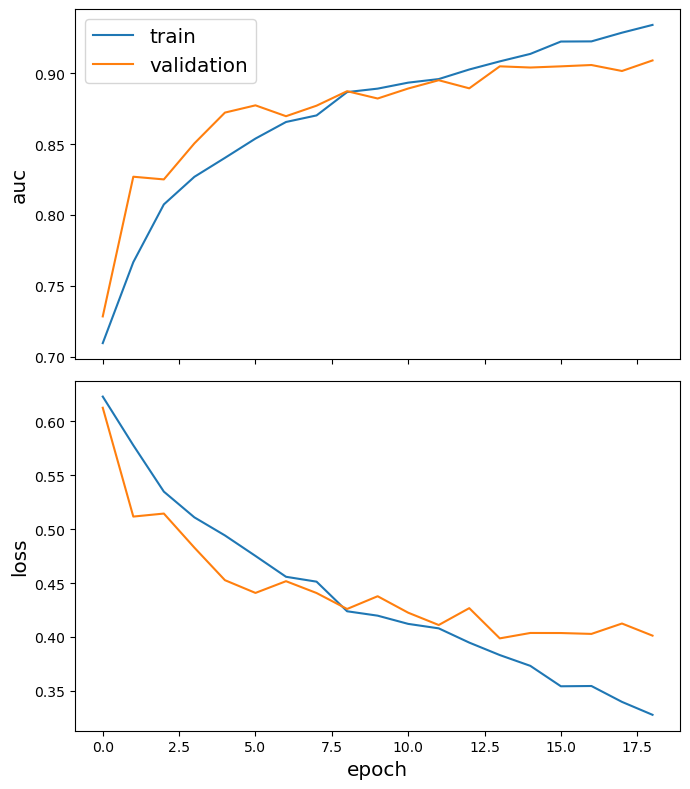

In [18]:
sg.utils.plot_history(history)

In [19]:
train_metrics = model.evaluate(train_flow, verbose=2)
test_metrics = model.evaluate(test_flow, verbose=2)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

300/300 - 1s - loss: 0.2804 - auc: 0.9534 - 1s/epoch - 4ms/step
500/500 - 2s - loss: 0.4028 - auc: 0.9030 - 2s/epoch - 4ms/step

Train Set Metrics of the trained model:
	loss: 0.2804
	auc: 0.9534

Test Set Metrics of the trained model:
	loss: 0.4028
	auc: 0.9030


In [20]:
predictions = model.predict(test_flow)

500/500 [==============================] - 4s 5ms/step


In [21]:
predictions

array([[0.9419401 ],
       [0.9673941 ],
       [0.7797605 ],
       ...,
       [0.1022625 ],
       [0.78573066],
       [0.12152016]], dtype=float32)

In [22]:
test = predictions>0.5 

In [23]:
test = test.astype('int8')

In [24]:
edge_ids_test

array([['CC1(C)CC(=O)c2cc3c(cc2O1)CC(C(C)(C)O)O3',
        'Truncatella angustata'],
       ['CCC(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C(C)C',
        'Prunus cornuta'],
       ['COc1cc2c3cc1Oc1c(OC)c(OC)cc4c1C(Cc1ccc(cc1)Oc1cc(ccc1O)CC3N(C)CC2)N(C)CC4',
        'Berberis aquifolium'],
       ...,
       ['CC=C(C)C(=O)OCC1=CC(O)C(C(C)C)C(OC(C)=O)CC(C)=CCC1',
        'Entada africana'],
       ['C=C1CCCC(C)(C)C1CCC(C)=CCCC1C(C)(O)CCC2C(C)(C)CCCC21C',
        'Acacia buxifolia'],
       ['OCc1ccc(O)cc1', 'Hoya bella']], dtype=object)

In [25]:
min(predictions)

array([0.0006728], dtype=float32)

In [26]:
test = test.flatten()

In [27]:
predictions[1]

array([0.9673941], dtype=float32)